In [1]:
# imports
from OfflineSRL.MDPDataset.old_dataset import *
from OfflineSRL.MDP.old_MDP import MDP
from OfflineSRL.MDP.ChainBandit import ChainBanditMDP
from OfflineSRL.MDP.ChainBanditState import ChainBanditState
from OfflineSRL.BPolicy.ChainBanditPolicy import ChainBanditPolicy
from OfflineSRL.OfflineLearners.offlineLearners import VI, PVI, SPVI, PesBandit

import copy
import numpy as np

In [2]:
def get_dataset(horizon = 3, neps = 50, third_action_prob = 0.2):
    # Initialize MDP and Policy
    mdp = ChainBanditMDP(num_states = horizon)
    policy = ChainBanditPolicy(mdp, third_action_prob = third_action_prob)
    
    # Generate data
    observations = []
    actions = []
    rewards = []
    terminals = []
    for eps in range(neps):
        for timestep in range(horizon+2):
            # Get state.
            # Add state to list.
            cur_state = copy.deepcopy(mdp.cur_state)
            observations.append(copy.deepcopy(cur_state.num_list))

            # Get action
            # Add action to list
            cur_action = policy._get_action(state = cur_state)
            actions.append(copy.deepcopy(cur_action))

            # Execute action
            reward, next_state = mdp.execute_agent_action(cur_action)
            # Add reward
            rewards.append(copy.deepcopy(reward))

            terminals.append(0)
        mdp.reset()
        terminals[-1] = 1
        
    # Convert to MDPDataset format
    observations = np.array(observations)
    actions = np.array(actions)
    rewards = np.array(rewards)
    terminals = np.array(terminals)

    dataset = MDPDataset(
        observations=observations,
        actions=actions,
        rewards=rewards,
        terminals=terminals,
    )
    
    return observations, policy, dataset

In [3]:
def evaluate_learner(option, observations, policy, dataset, horizon, neps = 5000):
    max_step_reward = 1
    abs_max_ep_reward = 1
    min_step_reward = 0
    if option == "VI":
        vi = VI(name = "vi", states = observations, actions = policy.actions, epLen = horizon)
    if option == "PVI":
        vi = PVI(name = "pvi", states = observations, actions = policy.actions, epLen = horizon, 
                 max_step_reward = max_step_reward, min_step_reward = min_step_reward, abs_max_ep_reward = abs_max_ep_reward)
    if option == "SPVI":
        vi = SPVI(name = "spvi", states = observations, actions = policy.actions, epLen = horizon, bpolicy = policy,
                  max_step_reward = max_step_reward, min_step_reward = min_step_reward, abs_max_ep_reward = abs_max_ep_reward)
    if option == "PSL":
        vi = PesBandit(name = "psl", states = observations, actions = policy.actions, epLen = horizon)
    vi.fit(dataset)
    mdp = ChainBanditMDP(num_states = horizon)
    viobservations = []
    viactions = []
    virewards = []
    viterminals = []
    for eps in range(neps):
        for timestep in range(horizon):
            # Get state.
            # Add state to list.
            cur_state = copy.deepcopy(mdp.cur_state)
            viobservations.append(copy.deepcopy(cur_state.num_list))

            # Get action
            # Add action to list
            cur_action = vi.act(copy.deepcopy(cur_state.num_list), timestep)
            viactions.append(copy.deepcopy(cur_action))

            # Execute action
            reward, next_state = mdp.execute_agent_action(cur_action)
            # Add reward
            virewards.append(copy.deepcopy(reward))

            viterminals.append(0)
        mdp.reset()
        viterminals[-1] = 1
    return np.sum(np.array(virewards))/neps

In [4]:
rew_dict = {}
option_list = ["PSL","PVI","SPVI"]
for option in option_list:
    rew_dict[option] = {}
n_runs = 10
horizon = 3
neps_list = [(i+1)*500 for i in range(40)]
for neps in neps_list:
    print(neps)
    for option in option_list:
        rew_dict[option][neps] = []
    for run in range(n_runs):
        observations, policy, dataset = get_dataset(horizon = horizon, neps = neps, third_action_prob = 0.8)
        for option in option_list:
            rew_dict[option][neps].append(evaluate_learner(option, copy.deepcopy(observations), policy, dataset, horizon))
            #print(option)
            #print(option, neps, evaluate_learner(option, copy.deepcopy(observations), policy, dataset, horizon))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000


In [5]:
rew = {}
err = {}
for option in option_list:
    rew[option] = []
    err[option] = []
for neps in neps_list:
    for option in option_list:
        rew[option].append(np.mean(rew_dict[option][neps]))
        err[option].append(np.std(rew_dict[option][neps])/np.sqrt(n_runs))

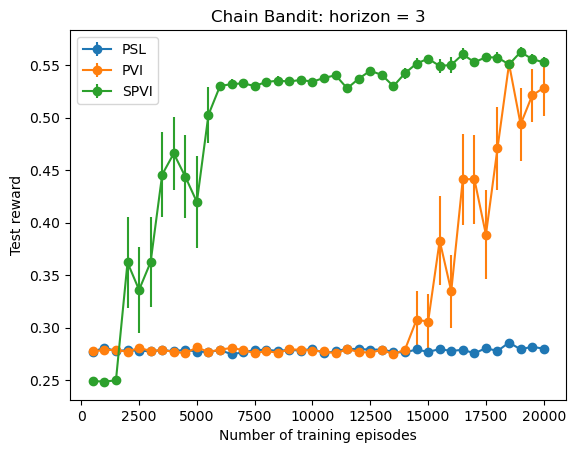

In [6]:
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

fig, ax = plt.subplots()
for option in option_list:
    x = neps_list
    y = rew[option]
    yerr = err[option]
    ax.errorbar(x, y,
                yerr=yerr,
                fmt='-o', label = option)


ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Test reward')
ax.set_title('Chain Bandit: horizon = '+str(horizon))
plt.legend()

plt.savefig('chainbandit-h=3-suopt=0.8.png')
plt.show()

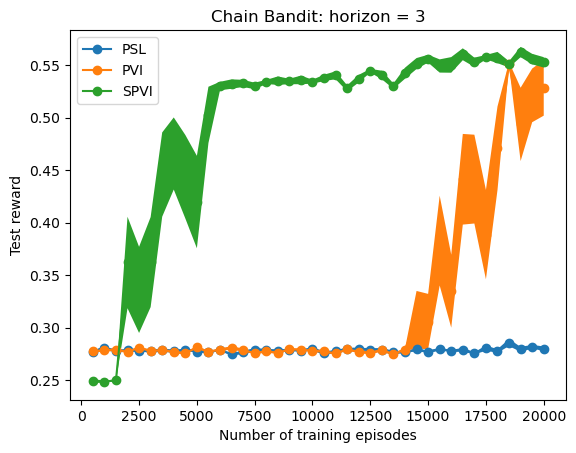

In [7]:
fig, ax = plt.subplots()
for option in option_list:
    x = neps_list
    y = np.array(rew[option])
    yerr = np.array(err[option])
    ax.plot(x, y, '-o', label = option)
    ax.fill_between(x, y-yerr, y+yerr)
    #ax.errorbar(x, y,
    #            yerr=yerr,
    #            fmt='-o', label = option)


ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Test reward')
ax.set_title('Chain Bandit: horizon = '+str(horizon))
plt.legend()

#x = np.linspace(0, 30, 30)
#y = np.sin(x/6*np.pi)
#error = np.random.normal(0.1, 0.02, size=y.shape)
#y += np.random.normal(0, 0.1, size=y.shape)

#plt.plot(x, y, 'k-')
#plt.fill_between(x, y-error, y+error)
plt.show()